# Simple example with only temporary price impact

In [1]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numba import vectorize
import os


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout
from keras import backend as K
tf.reset_default_graph()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
K.clear_session()



Using TensorFlow backend.


In [2]:
N = 100 # time steps
T = 1. # time horizon
sigma = 0.2 # volatility
alpha = 0.5 # temporary price impact exponent
dt = T/N
num_samples = 100000
num_shares = 1.
mismatch_penalty = 1000.
inventory_param = 10 # inventory penalty
num_epochs = 5

def power_impact_function(alpha):
    @vectorize(['float32(float32)'], target='cpu')
    def f(x):
        return x**alpha
    return f



## Parameters for the neural network

In [3]:
params = {"hidden1": 10, "hidden2": 10,  
              "hidden3": 66, 
              "droput1":0.45,  "droput2": 0.3,
              "optimizer": 'rmsprop', "epochs": 3}

## Simulate the asset price

In [4]:
%%time
data = np.random.normal(0, 1, (num_samples, N))*np.sqrt(dt)
timesteps = np.linspace(0, T-dt, N)

CPU times: user 425 ms, sys: 23.1 ms, total: 448 ms
Wall time: 452 ms


In [5]:
data.shape
data = np.sqrt(sigma) * np.cumsum(data, axis=1)

In [6]:
timeline = np.zeros_like(data)
timeline[:] = timesteps
timeline.shape

(100000, 100)

## Build the neural network

In [7]:
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from keras import optimizers

def tf_power(alpha):
    def f(x):
        return tf.pow(x, alpha)
    return f
    
batch_size = 32
times = Input(shape=(N,))
price = Input(shape=(N,))

hidden1 = Dense(params["hidden1"], activation='relu')(times) 
                    #kernel_initializer='uniform',
                    #kernel_regularizer=regularizers.l2(0))(x)
    
Dropout(params["droput1"])(hidden1)
    
hidden2 = Dense(params["hidden2"], activation='relu')(hidden1)
                #kernel_regularizer=regularizers.l2(0))(hidden1)
    
Dropout(params["droput2"])(hidden2)
    
#hidden3 = Dense(params["hidden3"], activation='relu', kernel_initializer='normal',
                    #kernel_regularizer=regularizers.l2(0))(hidden2)
    #hidden4 = Dense(100, activation='elu', kernel_initializer='normal')(hidden3)
    #hidden5 = Dense(10, activation='elu', kernel_initializer='normal')(hidden4)

logit = Dense(N, activation=None)(hidden2)

trading_speed = Dense(N, activation='softplus')(logit)
# vector of controls

#dt_t = tf.constant(dt, dtype=tf.float32)
#mismatch_penalty = tf.constant(mismatch_penalty)

temporary_impact_function = tf_power(alpha)
# vector of temporary price impacts

price_impact = temporary_impact_function(trading_speed)

assets_sold = dt * tf.reduce_sum(trading_speed, axis=1)


loss3 = mismatch_penalty * tf.square(tf.maximum(num_shares-assets_sold, 0.))
cum_sum = tf.zeros_like(loss3)
target = num_shares*tf.ones_like(cum_sum)

###############################################c
# compute the inventory penalty
for j in range(N):
    temp = tf.slice(trading_speed, [0, 0], [-1, j+1])
    addition = tf.square(tf.subtract(target, dt*tf.reduce_sum(temp, axis=1)))
    cum_sum = tf.add(cum_sum, addition)

inventory_penalty = inventory_param * dt * cum_sum
################################################        
        
loss1 = - tf.reduce_sum(tf.multiply(tf.subtract(price,price_impact), trading_speed), axis=1)
loss1 = tf.multiply(loss1, dt)

loss = tf.add_n([loss1, inventory_penalty, loss3])
def custom_loss(y_true, y_pred):
    return loss
#import keras.losses
#keras.losses.custom_loss = custom_loss



rmsprop = optimizers.RMSprop(lr=0.0001)
model = Model(inputs=[price, times], outputs=trading_speed)
model.compile(optimizer='rmsprop',loss=custom_loss, metrics=[])


/home/lukasz/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/lukasz/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/lukasz/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/lukasz/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/lukasz/.local/lib/python3.6/site-packages/tensorflow/pytho

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
Total params: 12,320
Trainable params: 12,320
Non-trainable params: 0
_________________________________________________________________


/home/lukasz/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/lukasz/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Epoch 1/3
100000/100000 [==============================] - 50s 497us/step - loss: 2.6156
Epoch 2/3
100000/100000 [==============================] - 50s 495us/step - loss: 2.4948
Epoch 3/3
100000/100000 [==============================] - 50s 496us/step - loss: 2.4914
dict_keys(['loss'])


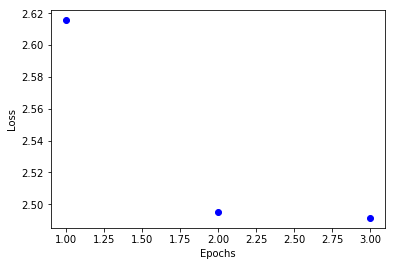

In [9]:
history = model.fit([data, timeline],timeline,
                    epochs=params["epochs"],
                    batch_size=32)

history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['loss']
epochs = range(1, params["epochs"]+1)

plt.plot(epochs, loss_values, 'bo', label="training_loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [10]:
dummy_price = np.zeros_like(data[0]).reshape(1,-1)
def f_predict(times_array):
    times_array = times_array.reshape(1,-1)
    result = model.predict([dummy_price,times_array])
    
    return result

/home/lukasz/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/lukasz/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


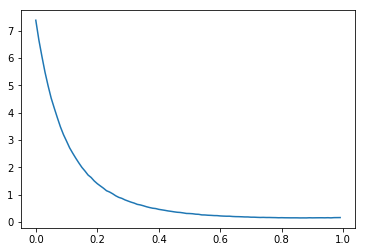

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(timesteps, f_predict(timesteps)[0])

The picture looks really smooth, as it should.

In [12]:
K.clear_session()

In [13]:
result_speed = f_predict(timesteps)

In [14]:
result_speed.mean(axis=1)

array([1.0114079], dtype=float32)

In [15]:
result_speed

array([[7.3807974 , 6.659346  , 6.0526333 , 5.477924  , 4.9831605 ,
        4.531805  , 4.168903  , 3.818184  , 3.482501  , 3.1964939 ,
        2.957977  , 2.7128022 , 2.5181723 , 2.3338149 , 2.1600642 ,
        1.9959865 , 1.8629822 , 1.7173469 , 1.6267382 , 1.5007236 ,
        1.401034  , 1.3175032 , 1.2357498 , 1.1422195 , 1.094808  ,
        1.0312135 , 0.95667833, 0.89886045, 0.8625133 , 0.80731225,
        0.76498103, 0.72373897, 0.689432  , 0.6435756 , 0.6226114 ,
        0.591568  , 0.55613434, 0.5273862 , 0.5026095 , 0.4894871 ,
        0.4606479 , 0.44265425, 0.42417055, 0.403226  , 0.3877267 ,
        0.36984533, 0.3541533 , 0.3465642 , 0.32977584, 0.31060836,
        0.3076261 , 0.3000949 , 0.28411746, 0.27870002, 0.25756076,
        0.25510544, 0.24546807, 0.24067889, 0.23308335, 0.23128578,
        0.21991532, 0.21352908, 0.20939699, 0.20979835, 0.19992524,
        0.19455148, 0.19280732, 0.18864529, 0.1826886 , 0.1823525 ,
        0.17354596, 0.17365138, 0.16809528, 0.16

In [16]:
data[:,0]

array([ 0.00498255,  0.00868984,  0.06544259, ..., -0.00926191,
        0.06041896, -0.01838103])